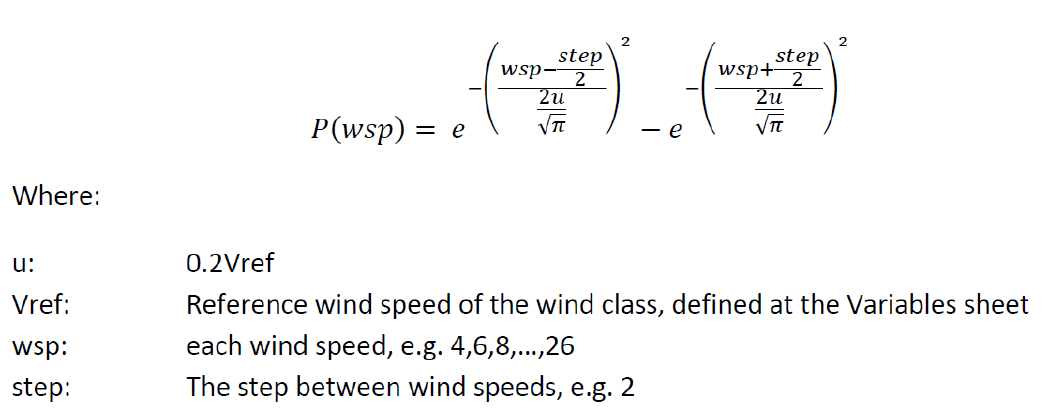

In [ ]:
import numpy as np


def propability_wsp(wsp, wind_class, step=1):
    """"""
    # Referense wind spped of the class
    if wind_class == 'I':
        V_ref = 50      
    elif wind_class == 'II':
        V_ref = 42.5
    elif wind_class == 'III':
        V_ref = 37.5
    else:
        raise ValueError('Wrong "wind_class" given. It should be "I"/"II"/"III"')
    u = 0.2*V_ref

    return np.exp(-((wsp-step/2)/(2*u/np.sqrt(np.pi)))**2) - np.exp(-((wsp+step/2)/(2*u/np.sqrt(np.pi)))**2)

In [2]:
import numpy as np

R_eq_list = [
    46860.78173262,
    60533.72498661,
    59165.75222735,
    49669.98028487,
    48249.13096179,
    41188.70573419,
    40341.05873765,
    39077.21951565,
    37340.02415617,
    36937.69987989,
    39649.01740049,
    43179.18330751,
    41795.27733207,
    42207.91706777,
    46612.72861644,
    48856.4751121,
    49077.04325018,
    54465.85842442,
    53021.0998996,
    54357.18578793
]

P_wsp_list = [
    0.06442809,
    0.0709227,
    0.07472189,
    0.07591763,
    0.0747455,
    0.07155162,
    0.06675382,
    0.06080169,
    0.05413969,
    0.04717648,
    0.04026251,
    0.03367663,
    0.02762128,
    0.02222493,
    0.01755019,
    0.01360521,
    0.01035688,
    0.00774379,
    0.00568809,
    0.0041053
]

n_seeds=6
n_eq_L=1E7
n_T=(20*365*24*60*60)
m=4

n_TS = n_T / n_seeds

# Just in case we accidentaly give list
R_eq_list = np.array(R_eq_list)
P_wsp_list = np.array(P_wsp_list)

# AEP Calculation

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from lacbox.io import load_stats


# Select if operational data or loads will be plotted
plot_operational_data = False

# Constants
SEEDS = 6
BB_PATH = Path.cwd().parent / 'our_design/BB_turb_stats.csv'  # path to mean steady stats
DTU_PATH = Path.cwd().parent / 'dtu_10MW/turb/dtu_10mw_turb_stats.hdf5'  # path to mean steady stats
BB_SUBFOLDER = 'tcb'
DTU_SUBFOLDER = 'tca'
if plot_operational_data == True:
    chan_ids_we_want = ['BldPit', 'RotSpd', 'Thrust', 'GenTrq', 'ElPow']
else:
    chan_ids_we_want = ['TbFA', 'TbSS', 'YbTilt', 'YbRoll', 'ShftTrs', 'OoPBRM', 'IPBRM']


# Dict to identify which HAWC2 descriptions correspond to which channels
CHAN_DESCS = {'BldPit': 'pitch1 angle',
              'RotSpd': 'rotor speed',
              'Thrust': 'aero rotor thrust',
              'GenTrq': 'generator torque',
              'ElPow': 'pelec',
              'TbFA': 'momentmx mbdy:tower nodenr:   1',
              'TbSS': 'momentmy mbdy:tower nodenr:   1',
              'YbTilt': 'momentmx mbdy:tower nodenr:  11',
              'YbRoll': 'momentmy mbdy:tower nodenr:  11',
              'ShftTrs': 'momentmz mbdy:shaft nodenr:   4',
              'OoPBRM': 'momentmx mbdy:blade1 nodenr:   1 coo: hub1',
              'IPBRM': 'momentmy mbdy:blade1 nodenr:   1 coo: hub1',
              'FlpBRM': 'momentmx mbdy:blade1 nodenr:   1 coo: blade1',
              'EdgBRM': 'momentmy mbdy:blade1 nodenr:   1 coo: blade1',
              'OoPHub': 'momentmx mbdy:hub1 nodenr:   1 coo: hub1',
              'IPHub': 'momentmy mbdy:hub1 nodenr:   1 coo: hub1',
              }

# what channels we want to plot
chan_ids = ['BldPit', 'RotSpd', 'Thrust', 'GenTrq', 'ElPow', 'TbFA', 'TbSS',
            'YbTilt', 'YbRoll', 'ShftTrs', 'OoPBRM', 'IPBRM']

chan_labels = [
    'Pitch angle [deg]',
    'Rotor speed [rad/s]',
    'Thrust [kN]',
    'Generator torque [Nm]',
    'Electrical power [W]',
    'Tower-base FA [kNm]',
    'Tower-base SS [kNm]',
    'Yaw-bearing tilt [kNm]',
    'Yaw-bearing roll [kNm]',
    'Shaft torsion [kNm]',
    'OoP root moment [kNm]',
    'IP root moment [kNm]'    
]

In [14]:
def extract_and_order_statistics(wsps, chan_df, seeds):
    """
    Extract and order:
     - wsp, max, mean, min for the points
     - wsp, mean_max, mean_mean, mean_min for the mean lines
    """

    # extract hawc2 wind and channel to plot from the HAWC2 stats
    val_wsp, val_max, val_mean, val_min = chan_df['wsp'], chan_df['max'], chan_df['mean'], chan_df['min']
    val_wsp, val_max, val_mean, val_min = np.array(val_wsp), np.array(val_max), np.array(val_mean), np.array(val_min)
    i_val = np.argsort(val_wsp)

    # Get mean of max/mean/min
    mean_max = np.average(val_max[i_val].reshape(-1, seeds), axis=1)
    mean_mean = np.average(val_mean[i_val].reshape(-1, seeds), axis=1)
    mean_min = np.average(val_min[i_val].reshape(-1, seeds), axis=1)

    points = {
        'wsp': val_wsp[i_val],
        'max': val_max[i_val],
        'mean': val_mean[i_val],
        'min': val_min[i_val]
    }

    lines = {
        'wsp': wsps,
        'max': mean_max,
        'mean': mean_mean,
        'min': mean_min
    }

    return points, lines

In [16]:
# load the data from the stats file
df_DTU, wsps_DTU = load_stats(DTU_PATH, subfolder=DTU_SUBFOLDER, statstype='turb')

# isolate the channel data and get statistics
chan_df_DTU = df_DTU.filter_channel(chan_id='ElPow', chan_desc_dict=CHAN_DESCS)

# extract and order statistics
points_DTU, lines_DTU = extract_and_order_statistics(wsps_DTU, chan_df_DTU, SEEDS)

In [23]:
power_DTU = lines_DTU['mean']

# Constants
hours_per_year = 8760  # Total hours in a year

# Calculate AEP by summing the product of power and probability for each wind speed bin
AEP_kWh = np.sum(power_DTU * P_wsp_list) * hours_per_year

# Output AEP in MWh for clarity
AEP_MWh = AEP_kWh / 1E9

print(f"Annual Energy Production (AEP): {AEP_MWh} GWh")

Annual Energy Production (AEP): 49.26800055286712 GWh
